<a href="https://colab.research.google.com/github/ArthiyaD/TroubleShooters/blob/Development/Model1_ACG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Loading libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import pickle
import json
import tensorflow as tf
from tensorflow import keras
from keras import models
import os
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Flatten,Input, Convolution2D, Dropout, LSTM, TimeDistributed, Embedding, Bidirectional, Activation, RepeatVector,Concatenate
from tensorflow.keras.models import Sequential, Model
#from tensorflow.keras.utils import np_utils
import random
from tensorflow.keras.preprocessing import image, sequence
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [ ]:
!pip install -U --no-cache-dir gdown --pre

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!gdown 1dctDtBJ0Tu-aNbEfO_WArvFCxunAienT
!gdown 1qJsBkPzWhW_jScCuUda50kaaLSP1980i

Downloading...
From: https://drive.google.com/uc?id=1dctDtBJ0Tu-aNbEfO_WArvFCxunAienT
To: /content/Flickr8k.text.zip
100% 1.81M/1.81M [00:00<00:00, 94.7MB/s]


In [ ]:
!unzip /content/Flickr8k.text.zip
!unzip /content/Flicker8k_Dataset.zip

Archive:  /content/Flickr8k.text.zip
  inflating: Flickr_8k.devImages.txt  
  inflating: Flickr_8k.testImages.txt  
  inflating: Flickr_8k.trainImages.txt  
  inflating: Flickr8k.lemma.token.txt  
  inflating: Flickr8k.token.txt      


In [ ]:
images_dir = os.listdir("./")

images_path = '/content/Flicker8k_Dataset/'
captions_path = '/content/Flickr8k.token.txt'
train_path = '/content/Flickr_8k.trainImages.txt'
val_path = '/content/Flickr_8k.devImages.txt'
test_path = '/content/Flickr_8k.testImages.txt'

captions = open(captions_path, 'r').read().split("\n")
x_train = open(train_path, 'r').read().split("\n")
x_val = open(val_path, 'r').read().split("\n")
x_test = open(test_path, 'r').read().split("\n")

print("Check 1")

Working 0


In [ ]:
# Loading captions as values and images as key in dictionary
tokens = {}

for ix in range(len(captions)-1):
    temp = captions[ix].split("#")
    if temp[0] in tokens:
        tokens[temp[0]].append(temp[1][2:])
    else:
        tokens[temp[0]] = [temp[1][2:]]

print("Check 2")

# Creating train, test and validation dataset files with header as 'image_id' and 'captions'
train_dataset = open('flickr_8k_train_dataset.txt','wb')
train_dataset.write(b"image_id\tcaptions\n")

val_dataset = open('flickr_8k_val_dataset.txt','wb')
val_dataset.write(b"image_id\tcaptions\n")

test_dataset = open('flickr_8k_test_dataset.txt','wb')
test_dataset.write(b"image_id\tcaptions\n")

Working 1 


18

In [ ]:
# Populating the above created files for train, test and validation dataset with image ids and captions for each of these images
for img in x_train:
    if img == '':
        continue
    for capt in tokens[img]:
        caption = "<start> "+ capt + " <end>"
        train_dataset.write((img+"\t"+caption+"\n").encode())
        train_dataset.flush()
train_dataset.close()

print("Check 3")

for img in x_test:
    if img == '':
        continue
    for capt in tokens[img]:
        caption = "<start> "+ capt + " <end>"
        test_dataset.write((img+"\t"+caption+"\n").encode())
        test_dataset.flush()
test_dataset.close()

print("Check 4")

for img in x_val:
    if img == '':
        continue
    for capt in tokens[img]:
        caption = "<start> "+ capt + " <end>"
        val_dataset.write((img+"\t"+caption+"\n").encode())
        val_dataset.flush()
val_dataset.close()

Working 3
Working 4


In [ ]:
# Loading 50 layer Residual Network Model and getting the summary of the model
model = ResNet50(include_top=False,weights='imagenet',input_shape=(224,224,3),pooling='avg')

# Helper function to process images
def preprocessing(img_path):
    im = image.load_img(img_path, target_size=(224,224,3))
    im = image.img_to_array(im)
    im = np.expand_dims(im, axis=0)
    return im

print("Check 5")

train_data = {}
ctr=0
for ix in x_train:
    if ix == "":
        continue
    if ctr >= 3000:
        break
    ctr+=1
    if ctr%1000==0:
        print(ctr)
    path = images_path + ix
    img = preprocessing(path)
    pred = model.predict(img).reshape(2048)
    train_data[ix] = pred

print("Check 6")

# opening train_encoded_images.p file and dumping it's content
with open("train_encoded_images.p", "wb") as pickle_f:
    pickle.dump(train_data, pickle_f )

94765736/94765736 [==============================] - 1s 0us/step
Working 6 
1/1 [==============================] - 0s 155ms/step
1000
1/1 [==============================] - 0s 141ms/step
2000
1/1 [==============================] - 0s 146ms/step
3000
1/1 [==============================] - 0s 150ms/step
Working 7


In [ ]:
# Loading image and its corresponding caption into a dataframe and then storing values from dataframe into 'ds'
pd_dataset = pd.read_csv("flickr_8k_train_dataset.txt", delimiter='\t')
ds = pd_dataset.values
print(ds.shape)

print("Check 7")

# Storing all the captions from ds into a list
sentences = []
for ix in range(ds.shape[0]):
    sentences.append(ds[ix, 1])
    
print(len(sentences))

print("Check 8")
# Splitting each captions stored in 'sentences' and storing them in 'words' as list of list
words = [i.split() for i in sentences]

# Creating a list of all unique words
unique = []
for i in words:
    unique.extend(i)
unique = list(set(unique))

print(len(unique))
vocab_size = len(unique)

# Vectorization
print("Check 9")
word_2_indices = {val:index for index, val in enumerate(unique)}
indices_2_word = {index:val for index, val in enumerate(unique)}

word_2_indices['UNK'] = 0
word_2_indices['raining'] = 8253

indices_2_word[0] = 'UNK'
indices_2_word[8253] = 'raining'

print(word_2_indices['<start>'])
print(indices_2_word[4011])
print(word_2_indices['<end>'])
print(indices_2_word[8051])

vocab_size = len(word_2_indices.keys())
print(vocab_size)

max_len = 0

for i in sentences:
    i = i.split()
    if len(i) > max_len:
        max_len = len(i)

print(max_len)


print("Check 10")
padded_sequences, subsequent_words = [], []

for ix in range(ds.shape[0]):
    partial_seqs = []
    next_words = []
    text = ds[ix, 1].split()
    text = [word_2_indices[i] for i in text]
    for i in range(1, len(text)):
        partial_seqs.append(text[:i])
        next_words.append(text[i])
    padded_partial_seqs = sequence.pad_sequences(partial_seqs, max_len, padding='post')

    next_words_1hot = np.zeros([len(next_words), vocab_size], dtype=np.bool)
    
    #Vectorization
    for i,next_word in enumerate(next_words):
        next_words_1hot[i, next_word] = 1
        
    padded_sequences.append(padded_partial_seqs)
    subsequent_words.append(next_words_1hot)
    
padded_sequences = np.asarray(padded_sequences)
subsequent_words = np.asarray(subsequent_words)

print(padded_sequences.shape)
print(subsequent_words.shape)

for ix in range(len(padded_sequences[5])):
    for iy in range(max_len):
        print(indices_2_word[padded_sequences[5][ix][iy]],)
    print("\n")

print(len(padded_sequences[5]))

print("Check 11")

num_of_images = 2000
captions = np.zeros([0, max_len])
next_words = np.zeros([0, vocab_size])

for ix in range(num_of_images):#img_to_padded_seqs.shape[0]):
    captions = np.concatenate([captions, padded_sequences[ix]])
    next_words = np.concatenate([next_words, subsequent_words[ix]])

np.save("captions.npy", captions)
np.save("next_words.npy", next_words)

print(captions.shape)
print(next_words.shape)

(30000, 2)
Working 8
30000
Working 9
8253
Working 10
4111
gifts
566
down
8254
40
Working 11


<ipython-input-14-896a71f81771>:70: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  next_words_1hot = np.zeros([len(next_words), vocab_size], dtype=np.bool)
<ipython-input-14-896a71f81771>:79: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  padded_sequences = np.asarray(padded_sequences)
<ipython-input-14-896a71f81771>:80: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays

(30000,)
(30000,)
<start>
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK


<start>
A
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK


<start>
A
little
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK


<start>
A
little
baby
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK


<start>
A
little
baby
plays
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK


<start>
A
little
baby
plays
croquet
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK

In [ ]:
with open('train_encoded_images.p', 'rb') as f:
    encoded_images = pickle.load(f, encoding="bytes")

imgs = []

for ix in range(ds.shape[0]):
    if ds[ix, 0] in encoded_images.keys():
        imgs.append(list(encoded_images[ds[ix, 0]]))

imgs = np.asarray(imgs)
print(imgs.shape)

images = []
for ix in range(num_of_images):
    for iy in range(padded_sequences[ix].shape[0]):
        images.append(imgs[ix])
images = np.asarray(images)
np.save("images.npy", images)

print(images.shape)

image_names = []

for ix in range(num_of_images):
    for iy in range(padded_sequences[ix].shape[0]):
        image_names.append(ds[ix, 0])
        
image_names = np.asarray(image_names)

np.save("image_names.npy", image_names)
print(len(image_names))


(15000, 2048)
(25493, 2048)
25493


In [ ]:
captions = np.load("captions.npy")
next_words = np.load("next_words.npy")

print(captions.shape)
print(next_words.shape)

images = np.load("images.npy")
print(images.shape)

imag = np.load("image_names.npy")
print(imag.shape)

(25493, 40)
(25493, 8254)
(25493, 2048)
(25493,)


In [ ]:
embedding_size = 128
max_len = 40
image_model = Sequential()

image_model.add(Dense(embedding_size, input_shape=(2048,), activation='relu'))
image_model.add(RepeatVector(max_len))

print(image_model.summary())

language_model = Sequential()

language_model.add(Embedding(input_dim=vocab_size, output_dim=embedding_size, input_length=max_len))
language_model.add(LSTM(256, return_sequences=True))
language_model.add(TimeDistributed(Dense(embedding_size)))

print("Check 13")
print(language_model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               262272    
                                                                 
 repeat_vector (RepeatVector  (None, 40, 128)          0         
 )                                                               
                                                                 
Total params: 262,272
Trainable params: 262,272
Non-trainable params: 0
_________________________________________________________________
None
Working 15
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 40, 128)           1056512   
                                                                 
 lstm (LSTM)                 (None, 40, 256)           394240    
            

In [ ]:
conca = Concatenate()([image_model.output, language_model.output])
x = LSTM(128, return_sequences=True)(conca)
x = LSTM(512, return_sequences=False)(x)
x = Dense(vocab_size)(x)
out = Activation('softmax')(x)
model = Model(inputs=[image_model.input, language_model.input], outputs = out)

# model.load_weights("../input/model_weights.h5")
model.compile(loss='categorical_crossentropy', optimizer='RMSprop', metrics=['accuracy'])
print(model.summary())

model.fit([images, captions], next_words, batch_size=512, epochs=200)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 embedding_input (InputLayer)   [(None, 40)]         0           []                               
                                                                                                  
 dense_input (InputLayer)       [(None, 2048)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 40, 128)      1056512     ['embedding_input[0][0]']        
                                                                                                  
 dense (Dense)                  (None, 128)          262272      ['dense_input[0][0]']            
                                                                                              

KeyboardInterrupt: ignored

In [ ]:
model.save("modelnew.h5")

In [ ]:
with open('word_2_indices.pickle', 'wb') as handle:
    pickle.dump(word_2_indices, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [ ]:
with open('indices_2_word.pickle', 'wb') as handle:
    pickle.dump(indices_2_word, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
tf.keras.models.save_model(model, "saved_model.hp5", save_format="h5")

In [ ]:
!gdown 1Xv3CVAUuQPZbgQJqWJbuiPx14hcApcj5

Downloading...
From: https://drive.google.com/uc?id=1Xv3CVAUuQPZbgQJqWJbuiPx14hcApcj5
To: /content/saved_model.hp5
100% 60.0M/60.0M [00:00<00:00, 72.5MB/s]


In [ ]:
saved_model = keras.models.load_model('/content/saved_model.hp5')

In [ ]:
#loading the word_2_indices pickle file
with open('/content/word_2_indices.pickle', 'rb') as handle:
     word_2_indices_data = pickle.load(handle)

word_2_indices = word_2_indices_data

#loading the indices_2_word pickle file
with open('/content/indices_2_word.pickle', 'rb') as handle:
    indices_2_word_data = pickle.load(handle)

indices_2_word = indices_2_word_data

1/1 [==============================] - 1s 1s/step
[2.654082   0.7669981  0.1396528  ... 1.0428021  0.         0.55966306]
1/1 [==============================] - 0s 53ms/step


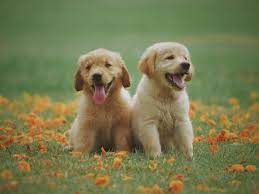

A tan dog is running through the grass with a toy in its mouth .


In [ ]:
def preprocessing(img_path):
    im = image.load_img(img_path, target_size=(224,224,3))
    im = image.img_to_array(im)
    im = np.expand_dims(im, axis=0)
    return im

def get_encoding(model1, img):
    image = preprocessing(img)
    pred = model1.predict(image).reshape(2048)
    return pred

resnet = ResNet50(include_top=False,weights='imagenet',input_shape=(224,224,3),pooling='avg')

#img = "/content/drive/My Drive/EAI Project/3759492488_592cd78ed1.jpg"

img = "/content/1.jpeg"

test_img = get_encoding(resnet, img)

print(test_img)

def predict_captions(image,model):
    start_word = ["<start>"]
    while True:
        par_caps = [word_2_indices[i] for i in start_word]
        #print("par_caps",par_caps)
        
        
        par_caps = sequence.pad_sequences([par_caps], maxlen=40, padding='post')
        #print("par_caps2",par_caps)
        
        
        preds = model.predict([np.array([image]), np.array(par_caps)])
        #print("preds",preds)
        
        word_pred = indices_2_word[np.argmax(preds[0])]
        #print("word_pred",word_pred)
        start_word.append(word_pred)
        
        if word_pred == "<end>" or len(start_word) >40:
            break
            
    return ' '.join(start_word[1:-1])

Argmax_Search = predict_captions(test_img,saved_model)

from IPython.display import Image, display
z = Image(filename=img)
display(z)

print(Argmax_Search)

In [ ]:
saved_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 embedding_input (InputLayer)   [(None, 40)]         0           []                               
                                                                                                  
 dense_input (InputLayer)       [(None, 2048)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 40, 128)      1056512     ['embedding_input[0][0]']        
                                                                                                  
 dense (Dense)                  (None, 128)          262272      ['dense_input[0][0]']            
                                                                                              

In [ ]:
saved_model.get_weights()

[array([[ 0.00267616, -0.06363375, -0.00206638, ...,  0.10030583,
         -0.06571005,  0.00536116],
        [ 0.06707235,  0.0225824 , -0.08542864, ...,  0.06323219,
         -0.11754885, -0.06688146],
        [ 0.03044012, -0.0153999 ,  0.0393231 , ..., -0.04646455,
         -0.02789613, -0.04100418],
        ...,
        [-0.01461886, -0.02659595, -0.00454225, ..., -0.03905152,
          0.04677505,  0.01274839],
        [ 0.01771936, -0.04404272, -0.00886517, ...,  0.06973108,
         -0.00464764, -0.14588466],
        [-0.00437882, -0.03145068, -0.02806268, ..., -0.0045684 ,
         -0.00102377, -0.0462034 ]], dtype=float32),
 array([[-3.9289561e-03,  4.7926839e-02, -2.7801225e-02, ...,
         -3.4373827e-02, -3.1291176e-02,  7.4576646e-02],
        [-8.7534636e-03,  7.6790266e-02, -4.7163006e-02, ...,
          2.3274826e-02, -1.1016859e-02, -1.1422624e-02],
        [-4.2700883e-02, -5.7653476e-02,  2.7212432e-02, ...,
         -1.5150400e-05,  4.5715224e-02, -7.0009507e-02]

In [ ]:
word_2_indices['a']

1589

In [ ]:
with open('file_dict.txt', 'w') as file:
     file.write(json.dumps(word_2_indices))

In [ ]:
word_2_indices

{'starting': 0,
 'Tattoed': 1,
 'mirror': 2,
 'explosion': 3,
 'contestants': 4,
 'racetrack': 5,
 'tower': 6,
 'fiery': 7,
 'african-american': 8,
 'pf': 9,
 'juming': 10,
 'artifacts': 11,
 'outfir': 12,
 'flying': 13,
 'wide': 14,
 'flipped': 15,
 'ramp': 16,
 'striped': 17,
 'floor': 18,
 'playy': 19,
 'sloped': 20,
 'mushrooms': 21,
 'waterpark': 22,
 'environment': 23,
 'sweatshirt': 24,
 'professional': 25,
 'oppsite': 26,
 'Rollerblades': 27,
 'wrapping': 28,
 'Seagulls': 29,
 'will': 30,
 'herself': 31,
 'fives': 32,
 'astonishment': 33,
 'bird': 34,
 'refuse': 35,
 'birthday': 36,
 'snowsuit': 37,
 'uncut': 38,
 'zips': 39,
 'reddish-brown': 40,
 '12': 41,
 'seaside': 42,
 'U.': 43,
 'Golden': 44,
 'rotweiler': 45,
 'balanced': 46,
 'liberty': 47,
 'chef': 48,
 'sweaters': 49,
 'tongue': 50,
 'studded': 51,
 'print': 52,
 'Ohio': 53,
 'thoroughly': 54,
 'Samsung': 55,
 'Near': 56,
 'skydiver': 57,
 'stair': 58,
 'during': 59,
 'squeak': 60,
 'thinks': 61,
 'uniquely-shaped': 

In [ ]:
indices_2_word

{0: 'UNK',
 1: 'Tattoed',
 2: 'mirror',
 3: 'explosion',
 4: 'contestants',
 5: 'racetrack',
 6: 'tower',
 7: 'fiery',
 8: 'african-american',
 9: 'pf',
 10: 'juming',
 11: 'artifacts',
 12: 'outfir',
 13: 'flying',
 14: 'wide',
 15: 'flipped',
 16: 'ramp',
 17: 'striped',
 18: 'floor',
 19: 'playy',
 20: 'sloped',
 21: 'mushrooms',
 22: 'waterpark',
 23: 'environment',
 24: 'sweatshirt',
 25: 'professional',
 26: 'oppsite',
 27: 'Rollerblades',
 28: 'wrapping',
 29: 'Seagulls',
 30: 'will',
 31: 'herself',
 32: 'fives',
 33: 'astonishment',
 34: 'bird',
 35: 'refuse',
 36: 'birthday',
 37: 'snowsuit',
 38: 'uncut',
 39: 'zips',
 40: 'reddish-brown',
 41: '12',
 42: 'seaside',
 43: 'U.',
 44: 'Golden',
 45: 'rotweiler',
 46: 'balanced',
 47: 'liberty',
 48: 'chef',
 49: 'sweaters',
 50: 'tongue',
 51: 'studded',
 52: 'print',
 53: 'Ohio',
 54: 'thoroughly',
 55: 'Samsung',
 56: 'Near',
 57: 'skydiver',
 58: 'stair',
 59: 'during',
 60: 'squeak',
 61: 'thinks',
 62: 'uniquely-shaped',
 